CASE STUDY - Insurance claim prediction model

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

DATA PREPROCESSING

In [15]:
def data_preprocessing(data):
    """
    Peforms preprocessing on the insurance claims data
    """

    # Check for null or missing values
    null_value_check = data.isna().sum()
    print("Null value check : \n",null_value_check)

    # Using Label encoder to convert categorical variables to numerical.
    # The categorical features present in the dataset are 'Gender', 'Vehicle_Age' and 'Previous_Vehicle_Damage'

    encoder = LabelEncoder()
    columns_to_encode = ['Gender', 'Vehicle_Age', 'Previous_Vehicle_Damage']
    
    for column in columns_to_encode:
        data[column] = encoder.fit_transform(data[column])

    # Create feature matrix X and target y
    features = ['Gender', 'Age', 'Driving_License', 'Region_Code','Previously_Insured', 'Vehicle_Age', 'Previous_Vehicle_Damage','Annual_Premium', 'Policy_Sales_Channel']
    
    # X consist of all feature columns 
    X = data[features]
    
    # y consists of response which has binary value 0 and 1
    y = data['Response']
    
    return X, y, features


In [16]:
data = pd.read_csv("claims_dummy_data.csv")
print('Size of dataset:',len(data))

# Call the data_preprocessing function
X, y, features = data_preprocessing(data)

Size of dataset: 382154
Null value check : 
 Claim ID                   0
Gender                     0
Age                        0
Driving_License            0
Region_Code                0
Previously_Insured         0
Vehicle_Age                0
Previous_Vehicle_Damage    0
Annual_Premium             0
Policy_Sales_Channel       0
Response                   0
dtype: int64


In [17]:
# Create Scaler object for scaling training and testing input features 
scaler = StandardScaler()

MODEL TRAINING

In [18]:
def train_model(X, y):
    """
    Train the Random Forest model
    """
    # Split the data 80-20 for training and testing
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Scale the features
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train Random Forest model
    model = RandomForestClassifier(n_estimators=50, random_state=42, class_weight='balanced')
    print(model.get_params)
    model.fit(X_train_scaled, y_train)
    
    return model, X_train_scaled, X_test_scaled, y_train, y_test, scaler

# Call the train model function
model, X_train_scaled, X_test_scaled, y_train, y_test, scaler = train_model(X, y)

<bound method BaseEstimator.get_params of RandomForestClassifier(class_weight='balanced', n_estimators=50,
                       random_state=42)>


MODEL EVALUATION

Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.91      0.90     63789
           1       0.48      0.43      0.45     12642

    accuracy                           0.83     76431
   macro avg       0.68      0.67      0.68     76431
weighted avg       0.82      0.83      0.82     76431

Confusion Matrix Explanation:

    True Negatives (TN): 57758 - Correctly predicted no claim
    False Positives (FP): 6031 - Incorrectly predicted claim
    False Negatives (FN): 7179 - Missed actual claims
    True Positives (TP): 5463 - Correctly predicted claims
    


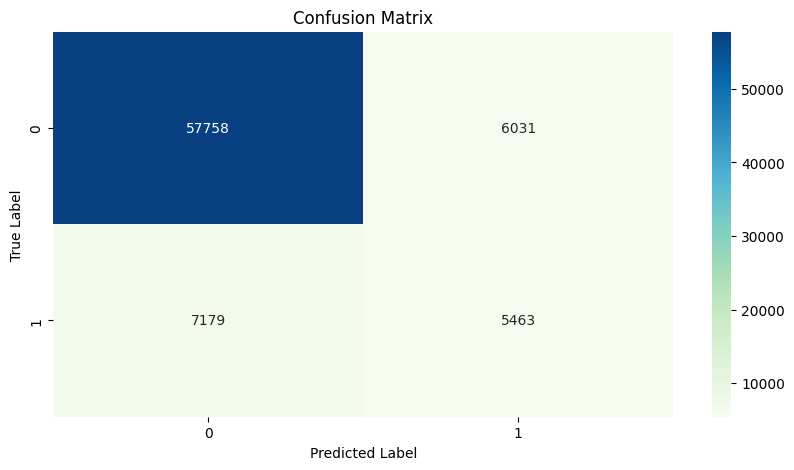

In [19]:
def evaluate_model(model, X_test_scaled, y_test):
    """
    Evaluate the model and print performance metrics
    """
    # Make predictions on test data
    y_pred = model.predict(X_test_scaled)
    
    # Print classification report
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred))
    
    # Generate confusion matrix result
    matrix = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = matrix.ravel()
    print("Confusion Matrix Explanation:")
    print(f"""
    True Negatives (TN): {tn} - Correctly predicted no claim
    False Positives (FP): {fp} - Incorrectly predicted claim
    False Negatives (FN): {fn} - Missed actual claims
    True Positives (TP): {tp} - Correctly predicted claims
    """)
    
    # Generate confusion matrix visualization 
    plt.figure(figsize=(10, 5))
    sns.heatmap(matrix, annot=True, fmt='d', cmap='GnBu')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# Evaluate the model
evaluate_model(model, X_test_scaled, y_test)

FEATURE IMPORTANCE

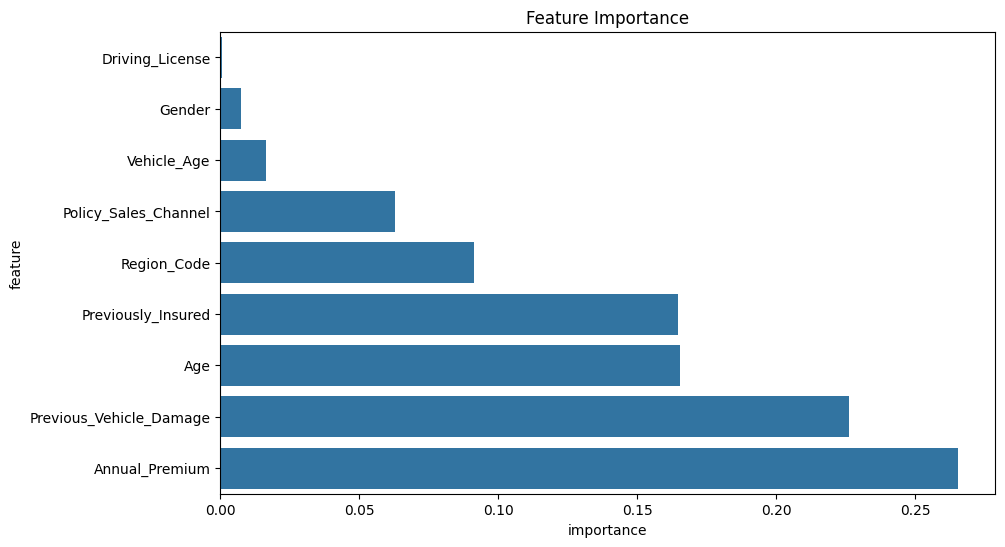

['Gender', 'Age', 'Driving_License', 'Region_Code', 'Previously_Insured', 'Vehicle_Age', 'Previous_Vehicle_Damage', 'Annual_Premium', 'Policy_Sales_Channel']


In [20]:
def analyze_feature_importance(model, features):
    """
    Analyze and plot feature importance
    """
    # Get feature importance also known as Gini importance to understand which feature influences the model
    importance = model.feature_importances_
    
    # Create DataFrame of features and their importance
    feature_importance = pd.DataFrame({
        'feature': features,
        'importance': importance
    })
    
    # Sort by importance from least to most important feature
    feature_importance = feature_importance.sort_values('importance')
    
    # Plot bar
    plt.figure(figsize=(10, 6))
    sns.barplot(x='importance', y='feature', data=feature_importance)
    plt.title('Feature Importance')
    plt.show()
    
    return feature_importance

# Analyze feature importance
feature_importance = analyze_feature_importance(model, features)
print(features)

ROC-AUC: 0.86


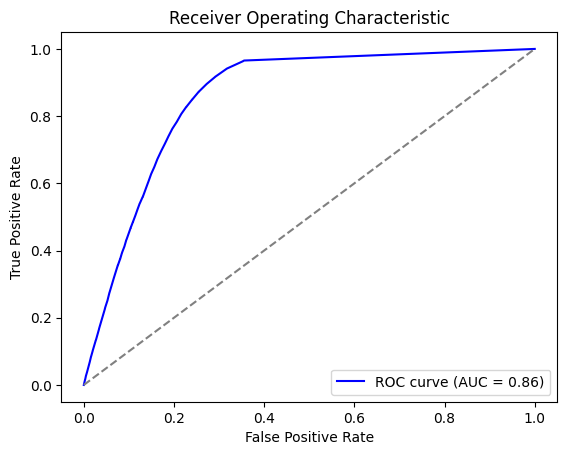

In [21]:
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

"""
AUC - ROC curve is a performance measurement for the classification problems at various threshold settings. 
ROC is a probability curve and AUC represents the degree or measure of separability.
"""

y_probs = model.predict_proba(X_test_scaled)[:, 1]  # probabilities for class 1

# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_test, y_probs)
print(f"ROC-AUC: {roc_auc:.2f}")

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Plot the ROC curve
plt.plot(fpr, tpr, color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [22]:
# Segment customers
high_risk = X[(X['Previous_Vehicle_Damage'] == 1) & (X['Age'] < 35)]
low_risk = X[(X['Previous_Vehicle_Damage'] == 0) & (X['Age'] >= 35)]

# Calculate claim rates in each segment
high_risk_rate = y[high_risk.index].mean()
low_risk_rate = y[low_risk.index].mean()
print(f"High-risk segment claim rate: {high_risk_rate}")
print(f"Low-risk segment claim rate: {low_risk_rate}")

High-risk segment claim rate: 0.2358651668708468
Low-risk segment claim rate: 0.005809984458291574


In [23]:
# Assess which region customers submits more claims 

# Group by 'region_code' and calculate the sum of claims in each region (assuming 'claim' column is binary: 1 for claim made, 0 for no claim)
region_claims = data.groupby('Region_Code')['Response'].sum()

# Sort the result to get the region with the most claims
region_claims_sorted = region_claims.sort_values(ascending=False)

# Calculate the percentage of total claims for each region
region_claims_percentage = (region_claims_sorted / region_claims_sorted.sum()) * 100

# Display the results
print(region_claims_percentage)

Region_Code
28    45.023242
8      6.929602
41     4.875321
46     4.322615
29     3.183655
3      2.565454
11     2.220412
35     2.020734
15     1.884954
30     1.857798
33     1.718822
18     1.530327
36     1.440872
45     1.316273
47     1.234805
39     1.212441
50     1.060686
14     0.937685
7      0.908931
38     0.897749
6      0.881775
13     0.771553
37     0.769956
24     0.725228
23     0.661331
48     0.640565
4      0.607019
12     0.605422
21     0.575071
2      0.554304
19     0.551109
10     0.525551
32     0.458459
43     0.436095
9      0.394562
27     0.357822
17     0.348237
20     0.292328
26     0.292328
5      0.276353
40     0.276353
31     0.274756
0      0.231626
34     0.217249
16     0.217249
49     0.194885
1      0.159742
25     0.153352
22     0.135781
42     0.076676
52     0.073481
51     0.067092
44     0.054312
Name: Response, dtype: float64


MODEL PREDICTION

In [24]:
def predict(model, scaler, input_data):
    """
    Predict if customer will claim an insurance
    """
    # Scale the input data as the model is trained on scaled feature
    input_scaled_data = scaler.transform(input_data)

    prediction = model.predict(input_scaled_data)

    return prediction

def predict_claim_probability(model, scaler, input_data):
    """
    Predict the probability of a claim for new customer data
    """
    # Scale the input data as the model is trained on the scaled feature
    input_scaled_data = scaler.transform(input_data)
    
    # Get probability predictions on data 
    prediction_probability = model.predict_proba(input_scaled_data)
    # print(prediction_probability)
    return prediction_probability[:,1]  # Return probability of positive class



In [25]:
# Predict on new customer
new_customer = X.iloc[[14]]  

# Predicts and provides binary result 
prediction = predict(model, scaler, new_customer)
print(f"Prediction if the customer will claim an insurance: {prediction}")

# Predicts and provides probability value 
claim_probability = predict_claim_probability(model, scaler, new_customer)

print(f"Predicted claim probability for new customer: {claim_probability[0]:.2%}") 


Prediction if the customer will claim an insurance: [1]
Predicted claim probability for new customer: 70.00%


HYPER PARAMETER TUNING

In [26]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV 
param_grid = { 
    'n_estimators': [50, 100], 
    'max_features': ['sqrt', 'log2'], 
    'max_depth': [6, 9], 
    'max_leaf_nodes': [6, 9]
}

grid_search = GridSearchCV(RandomForestClassifier(), 
                           param_grid=param_grid, n_jobs=-1) 
grid_search.fit(X_train_scaled, y_train) 
print(grid_search.best_estimator_)

RandomForestClassifier(max_depth=6, max_leaf_nodes=6, n_estimators=50)


In [27]:
model_grid = RandomForestClassifier(max_depth=6, 
									max_features="log2", 
									max_leaf_nodes=6, 
									n_estimators=100,
                                    class_weight='balanced') 
model_grid.fit(X_train_scaled, y_train) 
y_pred_grid = model_grid.predict(X_test_scaled) 
print(classification_report(y_pred_grid, y_test, zero_division=1)) 

              precision    recall  f1-score   support

           0       0.71      0.99      0.83     46208
           1       0.95      0.40      0.56     30223

    accuracy                           0.75     76431
   macro avg       0.83      0.69      0.69     76431
weighted avg       0.81      0.75      0.72     76431



In [28]:
random_search = RandomizedSearchCV(RandomForestClassifier(), 
								param_grid) 
random_search.fit(X_train_scaled, y_train) 
print(random_search.best_estimator_) 

RandomForestClassifier(max_depth=6, max_leaf_nodes=6)


In [29]:
model_random = RandomForestClassifier(max_depth=6, 
									max_features='log2', 
									max_leaf_nodes=9, 
									n_estimators=50,
                                    class_weight='balanced') 
model_random.fit(X_train_scaled, y_train) 
y_pred_rand = model_random.predict(X_test_scaled) 
print(classification_report(y_pred_rand, y_test, zero_division=1)) 


              precision    recall  f1-score   support

           0       0.71      0.99      0.83     46208
           1       0.95      0.40      0.56     30223

    accuracy                           0.75     76431
   macro avg       0.83      0.69      0.69     76431
weighted avg       0.81      0.75      0.72     76431

